#ARIMA-XGBoost

In [1]:
#import libraries
import pandas as pd
import numpy as np
import yfinance as yf
from google.colab import drive
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
import statsmodels.api as sm

In [4]:
drive.mount('/content/gdrive')

#import time series
sp500_data = pd.read_csv('/content/gdrive/MyDrive/università/Machine_learning/Project_code/sp500_data.csv', index_col=0)
sp500_data = sp500_data.iloc[2:] #remove the first 2 rows that don't contain the time series
sp500_data.index.name = 'Date'
sp500_data.index = pd.to_datetime(sp500_data.index)
# sp500_data['Adj Close'] = sp500_data['Adj Close'].astype(float)
# sp500_data['Close'] = sp500_data['Close'].astype(float)
# sp500_data['High'] = sp500_data['High'].astype(float)
# sp500_data['Low'] = sp500_data['Low'].astype(float)
# sp500_data['Open'] = sp500_data['Open'].astype(float)
# sp500_data['Volume'] = sp500_data['Volume'].astype(float)


#drop columns
sp500_data.drop(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Log Return'], axis=1, inplace=True)


#import ARIMA residuals
residuals = pd.read_csv('/content/gdrive/MyDrive/università/Machine_learning/Project_code/residuals.csv', index_col=0)
sp500_data['Residuals'] = residuals.values

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


ValueError: Length of values (6269) does not match length of index (6272)

##Feature Engineering

In [3]:
#time features
sp500_data['Year'] = sp500_data.index.year
sp500_data['Month'] = sp500_data.index.month
sp500_data['Day'] = sp500_data.index.day
sp500_data['Index_hash'] = sp500_data.index.map(lambda x: hash(x))

#lag features
for lag in (1,7,14,28,365):
  sp500_data[f'lag_{lag}'] = sp500_data['Residuals'].shift(lag)

#rolling features
for window in (7,14,28):
  sp500_data[f'rolling_mean_{window}'] = sp500_data['Residuals'].rolling(window=window).mean()
  sp500_data[f'rolling_std_{window}'] = sp500_data['Residuals'].rolling(window=window).std()
  sp500_data[f'rolling_skew_{window}'] = sp500_data['Residuals'].rolling(window=window).skew()


#substitute NaN values with 0
sp500_data.fillna(0, inplace=True)


#visualize
sp500_data

,Volume,Residuals,Year,Month,Day,Index_hash,lag_1,lag_7,lag_14,lag_28,lag_365,rolling_mean,rolling_std,rolling_skew
Date,,,,,,,,,,,,,,
2000-01-03,931800000,-0.000211,2000,1,3,9136730324360731070,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2000-01-04,1009000000,-0.039333,2000,1,4,1029675069736765505,-0.000211,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2000-01-05,1085500000,-0.002698,2000,1,5,1922856648053048946,-0.039333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2000-01-06,1092300000,0.000424,2000,1,6,-8766460414895398971,-0.002698,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2000-01-07,1225200000,0.027058,2000,1,7,-2359862444703268499,0.000424,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-25,5633150000,0.002805,2024,11,25,-4540551055362639800,0.003251,-0.006279,0.011980,0.004458,0.000608,0.000664,0.007772,0.338546
2024-11-26,3835170000,0.005495,2024,11,26,-1382019561898071799,0.002805,-0.013502,0.024771,-0.000382,0.011894,0.000874,0.007822,0.254884
2024-11-27,3363340000,-0.004019,2024,11,27,-7837944188065231019,0.005495,0.003700,0.007193,0.003753,-0.003889,0.000597,0.007854,0.354416


In [ ]:
def create_dataset(data, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(data) - n_steps_in - n_steps_out + 1):
        X.append(data[i : i + n_steps_in])
        y.append(data[i + n_steps_in : i + n_steps_in + n_steps_out])
    return np.array(X), np.array(y)

n_steps_in, n_steps_out = 5, 3
X, y = create_dataset(df['series'].values, n_steps_in, n_steps_out)

,Volume,Residuals,Year,Month,Day,Index_hash,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean,rolling_std,rolling_skew
Date,,,,,,,,,,,,,,,,
2000-01-03,931800000,-0.000211,2000,1,3,-8421100492639744160,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2000-01-04,1009000000,-0.039333,2000,1,4,7159496470038774108,-0.000211,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2000-01-05,1085500000,-0.002698,2000,1,5,-3561126286665969775,-0.039333,-0.000211,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2000-01-06,1092300000,0.000424,2000,1,6,-869902046584145464,-0.002698,-0.039333,-0.000211,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2000-01-07,1225200000,0.027058,2000,1,7,-822671413969413893,0.000424,-0.002698,-0.039333,-0.000211,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-25,5633150000,0.002805,2024,11,25,9163837315763123413,0.003251,0.005116,-0.000189,0.003745,0.003700,-0.013502,-0.006279,0.000704,0.006470,-2.326337
2024-11-26,3835170000,0.005495,2024,11,26,-7495868104694279503,0.002805,0.003251,0.005116,-0.000189,0.003745,0.003700,-0.013502,0.003418,0.001862,-1.201305
2024-11-27,3363340000,-0.004019,2024,11,27,-1905966387557973480,0.005495,0.002805,0.003251,0.005116,-0.000189,0.003745,0.003700,0.002315,0.003354,-1.309625


In [ ]:
series = np.sin(0.1 * np.arange(200)) + np.random.randn(200) * 0.1

# Prepare data for supervised learning
df = pd.DataFrame({'series': series})
for i in range(1, 6):
    df[f'lag_{i}'] = df['series'].shift(i)
df = df.dropna()

# Define a function to create input features and target variables for multi-step forecasting
def create_dataset(data, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(data) - n_steps_in - n_steps_out + 1):
        X.append(data[i : i + n_steps_in])
        y.append(data[i + n_steps_in : i + n_steps_in + n_steps_out])
    return np.array(X), np.array(y)

n_steps_in, n_steps_out = 5, 3
X, y = create_dataset(df['series'].values, n_steps_in, n_steps_out)

X

array([[ 0.35188062,  0.52223298,  0.77731015,  0.66781102,  0.9877558 ],
       [ 0.52223298,  0.77731015,  0.66781102,  0.9877558 ,  0.83486196],
       [ 0.77731015,  0.66781102,  0.9877558 ,  0.83486196,  0.8108757 ],
       [ 0.66781102,  0.9877558 ,  0.83486196,  0.8108757 ,  0.82764725],
       [ 0.9877558 ,  0.83486196,  0.8108757 ,  0.82764725,  0.91628902],
       [ 0.83486196,  0.8108757 ,  0.82764725,  0.91628902,  1.08630504],
       [ 0.8108757 ,  0.82764725,  0.91628902,  1.08630504,  1.07450581],
       [ 0.82764725,  0.91628902,  1.08630504,  1.07450581,  1.00358229],
       [ 0.91628902,  1.08630504,  1.07450581,  1.00358229,  0.80827841],
       [ 1.08630504,  1.07450581,  1.00358229,  0.80827841,  0.95865422],
       [ 1.07450581,  1.00358229,  0.80827841,  0.95865422,  1.00633104],
       [ 1.00358229,  0.80827841,  0.95865422,  1.00633104,  0.87579235],
       [ 0.80827841,  0.95865422,  1.00633104,  0.87579235,  0.79372838],
       [ 0.95865422,  1.00633104,  0.8

In [ ]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x) #window
        y.append(_y) #label

    return np.array(x),np.array(y)


#create sliding windows
seq_length = 28
x, y = sliding_windows(sp500_data, seq_length)
print(x.shape)
print(y.shape)

KeyError: 28

##Fast Fourier Transformation

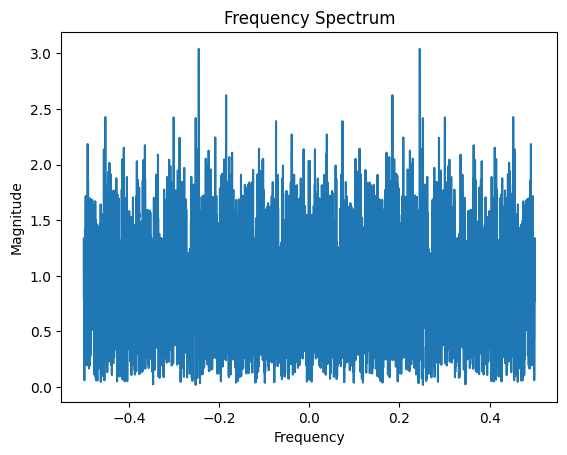

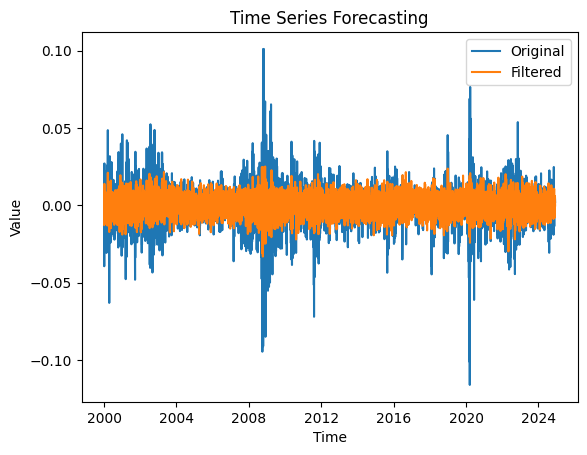

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft


# Perform Fast Fourier Transform (FFT)
fft_values = fft(sp500_data['Residuals'].values)

# Get the magnitude and frequencies
fft_magnitude = np.abs(fft_values)
frequencies = np.fft.fftfreq(len(sp500_data['Residuals']))

# Plot the frequency spectrum
plt.plot(frequencies, fft_magnitude)
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.title('Frequency Spectrum')
plt.show()

# Filter out the low magnitude frequencies
threshold = 1.5
fft_values_filtered = fft_values.copy()
fft_values_filtered[fft_magnitude < threshold] = 0

# Perform the inverse Fast Fourier Transform (IFFT)
filtered_time_series = ifft(fft_values_filtered)

filtered_time_series = pd.Series(filtered_time_series.real)
filtered_time_series.index = sp500_data.index
# Plot the original and filtered time series
plt.plot(sp500_data['Residuals'], label='Original')
plt.plot(filtered_time_series, label='Filtered')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series Forecasting')
plt.legend()
plt.show()

In [ ]:
# ---- FEATURE EXTRACTION USING FFT ----

fft_features = pd.DataFrame()

# Feature 1: Magnitudes of the top N dominant frequencies
top_n = 5
top_frequencies_idx = np.argsort(fft_magnitude)[-top_n:]  # Get indices of top N magnitudes
top_frequencies = frequencies[top_frequencies_idx]  # Get corresponding frequencies
top_magnitudes = fft_magnitude[top_frequencies_idx]  # Get corresponding magnitudes

# Add top frequencies and magnitudes as features
for i in range(top_n):
    fft_features[f"freq_{i+1}"] = [top_frequencies[i]]
    fft_features[f"mag_{i+1}"] = [top_magnitudes[i]]

# Feature 2: Total energy in the frequency domain (sum of all magnitudes)
fft_features['total_energy'] = [np.sum(fft_magnitude)]

# Feature 3: Frequency of the maximum magnitude (dominant frequency)
fft_features['dominant_frequency'] = [frequencies[np.argmax(fft_magnitude)]]

# Feature 4: Phase angle of the dominant frequency (timing information)
dominant_phase = np.angle(fft_values[np.argmax(fft_magnitude)])
fft_features['dominant_phase'] = [dominant_phase]

# Show the extracted features
print(fft_features)

     freq_1     mag_1    freq_2     mag_2    freq_3     mag_3    freq_4  \
0 -0.452225  2.426612 -0.184399  2.622957  0.184399  2.622957  0.245015   

      mag_4    freq_5     mag_5  total_energy  dominant_frequency  \
0  3.038923 -0.245015  3.038923   5344.371977            0.245015   

   dominant_phase  
0        2.276657  


##Scaling

Mean Squared Error: 1.237594869003609


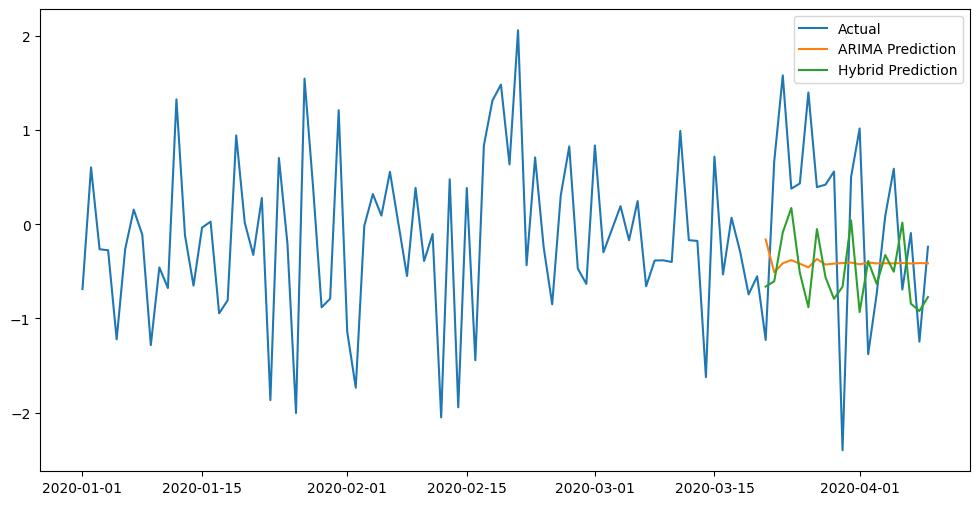

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Step 1: Load and preprocess data
# Replace this with your own time series data
data = pd.Series(np.random.randn(100), index=pd.date_range(start='2020-01-01', periods=100, freq='D'))

# Train-test split
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Step 2: Fit ARIMA model on training data
arima_model = ARIMA(train, order=(5, 1, 0))
arima_fit = arima_model.fit()

# Predict with ARIMA model
arima_pred = arima_fit.forecast(steps=len(test))

# Step 3: Calculate residuals on training data
residuals = train - arima_fit.fittedvalues

# Step 4: Feature engineering on residuals
def create_features(data, lags):
    features = pd.DataFrame(index=data.index)
    for lag in range(1, lags + 1):
        features[f'lag_{lag}'] = data.shift(lag)
    features.dropna(inplace=True)
    return features

lags = 5
train_features = create_features(residuals, lags)
train_labels = residuals.iloc[lags:]

# Step 5: Fit Random Forest model on residuals
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(train_features, train_labels)

# Step 6: Prepare test data features for Random Forest
test_residuals = test - arima_pred
test_features = create_features(pd.concat([residuals[-lags:], test_residuals]), lags)
test_features = test_features[-len(test):]  # Align with test set length

# Predict residuals with Random Forest
rf_pred_residuals = rf_model.predict(test_features)

# Combine ARIMA predictions with RF residual predictions
final_pred = arima_pred + rf_pred_residuals

# Step 7: Evaluate the model
mse = mean_squared_error(test, final_pred)
print(f'Mean Squared Error: {mse}')

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data.index, data, label='Actual')
plt.plot(test.index, arima_pred, label='ARIMA Prediction')
plt.plot(test.index, final_pred, label='Hybrid Prediction')
plt.legend()
plt.show()

Mean Squared Error: 0.0478


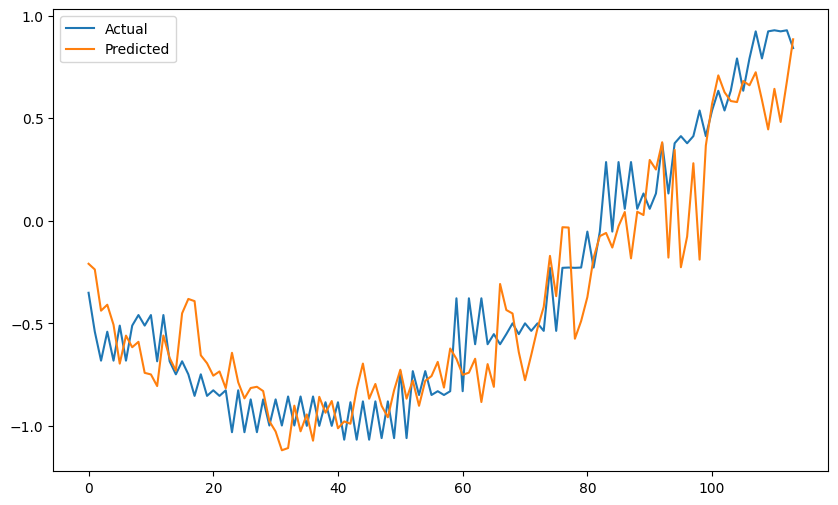

In [ ]:
# XGBoosting.com
# Multi-step Univariate Time Series Forecasting with XGBoost and MultiOutputRegressor
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Generate a synthetic univariate time series dataset
series = np.sin(0.1 * np.arange(200)) + np.random.randn(200) * 0.1
#series = np.linspace(0,10,100)

# Prepare data for supervised learning
df = pd.DataFrame({'series': series})
for i in range(1, 6):
    df[f'lag_{i}'] = df['series'].shift(i)
df = df.dropna()

# Define a function to create input features and target variables for multi-step forecasting
def create_dataset(data, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(data) - n_steps_in - n_steps_out + 1):
        X.append(data[i : i + n_steps_in])
        y.append(data[i + n_steps_in : i + n_steps_in + n_steps_out])
    return np.array(X), np.array(y)

n_steps_in, n_steps_out = 5, 3
X, y = create_dataset(df['series'].values, n_steps_in, n_steps_out)

# Chronological split of data into train and test sets
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Initialize an XGBRegressor model wrapped in a MultiOutputRegressor
base_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model = MultiOutputRegressor(base_model)

# Fit the model on the training data
model.fit(X_train, y_train)

# Make multi-step predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")

# Visualize the actual vs. predicted values for the test set
plt.figure(figsize=(10, 6))
plt.plot(y_test.flatten(), label='Actual')
plt.plot(y_pred.flatten(), label='Predicted')
plt.legend()
plt.show()

In [ ]:
y_pred.flatten()

array([-0.20951171, -0.23726822, -0.43803433, -0.4091096 , -0.5063556 ,
       -0.6961499 , -0.5595248 , -0.61617005, -0.5897728 , -0.7410125 ,
       -0.74871594, -0.80541   , -0.55900264, -0.6681591 , -0.7303544 ,
       -0.4510199 , -0.38081658, -0.39149654, -0.6553535 , -0.69409513,
       -0.7547295 , -0.7340396 , -0.8160131 , -0.64327675, -0.7870039 ,
       -0.86530614, -0.8148014 , -0.8088791 , -0.8296812 , -0.9767418 ,
       -1.0267836 , -1.1182636 , -1.1073748 , -0.9008088 , -1.0258497 ,
       -0.9435523 , -1.0715938 , -0.8577539 , -0.93537766, -0.8782799 ,
       -1.0110973 , -0.9776052 , -0.98900056, -0.82024515, -0.6957392 ,
       -0.8668281 , -0.79523176, -0.9015528 , -0.95743656, -0.8257406 ,
       -0.72584796, -0.8668281 , -0.77844363, -0.9015528 , -0.77968144,
       -0.7567277 , -0.6876323 , -0.8128275 , -0.62241995, -0.6726155 ,
       -0.7505117 , -0.74013686, -0.6722889 , -0.88305324, -0.69828707,
       -0.80903333, -0.3080175 , -0.4347518 , -0.4516922 , -0.63

In [ ]:
y_pred

array([[-0.20951171, -0.23726822, -0.43803433],
       [-0.4091096 , -0.5063556 , -0.6961499 ],
       [-0.5595248 , -0.61617005, -0.5897728 ],
       [-0.7410125 , -0.74871594, -0.80541   ],
       [-0.55900264, -0.6681591 , -0.7303544 ],
       [-0.4510199 , -0.38081658, -0.39149654],
       [-0.6553535 , -0.69409513, -0.7547295 ],
       [-0.7340396 , -0.8160131 , -0.64327675],
       [-0.7870039 , -0.86530614, -0.8148014 ],
       [-0.8088791 , -0.8296812 , -0.9767418 ],
       [-1.0267836 , -1.1182636 , -1.1073748 ],
       [-0.9008088 , -1.0258497 , -0.9435523 ],
       [-1.0715938 , -0.8577539 , -0.93537766],
       [-0.8782799 , -1.0110973 , -0.9776052 ],
       [-0.98900056, -0.82024515, -0.6957392 ],
       [-0.8668281 , -0.79523176, -0.9015528 ],
       [-0.95743656, -0.8257406 , -0.72584796],
       [-0.8668281 , -0.77844363, -0.9015528 ],
       [-0.77968144, -0.7567277 , -0.6876323 ],
       [-0.8128275 , -0.62241995, -0.6726155 ],
       [-0.7505117 , -0.74013686, -0.672

#XGBOOST